In [71]:
import pickle
import networkx as nx
import numpy as np
import itertools
from collections import Counter
from scipy import stats
from community import community_louvain
import matplotlib.pyplot as plt

In [10]:
with open("graph_largest.pkl", "rb") as f:
    graph_largest = pickle.load(f)
    
with open("graph.pkl", "rb") as f:
    graph = pickle.load(f)

### Network homophily based on sentiment

Homophily measures the tendency of individuals to associate and bond with similar others in a network. In our case, we will calculate how similar the sentiments of connected movies are. This could reveal if actor-driven sentiment spreads across the network

In [15]:
# Define similarity of sentiments
values = nx.get_node_attributes(graph, 'adjusted_sentiment')
range_of_values = max(values.values()) - min(values.values())
def similarity(u, v):
    return 1 - abs(values[u] - values[v]) / range_of_values

# Calculate observed mean similarity
similarities = [similarity(u, v) for u, v in graph.edges]
mean_similarity_observed = np.mean(similarities)

# Generate a null model by shuffling node attributes
shuffled_values = list(values.values())
np.random.shuffle(shuffled_values)
shuffled_values_dict = dict(zip(graph.nodes, shuffled_values))
def null_similarity(u, v):
    return 1 - abs(shuffled_values_dict[u] - shuffled_values_dict[v]) / range_of_values

# Calculate null mean similarity
null_similarities = [null_similarity(u, v) for u, v in graph.edges]
mean_similarity_null = np.mean(null_similarities)

# Compare observed and null similarities
homophily_index = (mean_similarity_observed - mean_similarity_null) / mean_similarity_null

print(f"Observed Mean Similarity: {mean_similarity_observed}")
print(f"Null Mean Similarity: {mean_similarity_null}")
print(f"Homophily Index: {homophily_index}")

Observed Mean Similarity: 0.8592399754167913
Null Mean Similarity: 0.8455425518328855
Homophily Index: 0.01619956743065603


Homophily index value is approximately 0.016. This indicates that nodes that are connected do not have a much larger similarity of sentiment than they would have if they were randomly connected.

### Total actor popularities compared with earnings and sentiment

In [54]:
# Find actor popularity in movies
appearances = nx.get_node_attributes(graph, 'actors')
flattened_appearances_list = list(itertools.chain.from_iterable(list(appearances.values())))
appearances_count = Counter(flattened_appearances_list)

# Add total popularity attribute
for node in graph.nodes:
    total_actor_popularity = sum([appearances_count[actor] for actor in appearances[node]])
    graph.nodes[node]["total_actor_popularity"] = total_actor_popularity
    
# Calculate the Pearson and Spearman correlation coefficients for total popularity and profit
total_actor_popularity = list(nx.get_node_attributes(graph, "total_actor_popularity").values())
profit = list(nx.get_node_attributes(graph, "profit").values())
pearson_corr, pearson_p = stats.pearsonr(total_actor_popularity, profit)
spearman_corr, spearman_p = stats.spearmanr(total_actor_popularity, profit)

print(f"---- Total actor popularity vs profit ----")
print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")

# Calculate the Pearson and Spearman correlation coefficients for total popularity and profit
adjusted_sentiment = list(nx.get_node_attributes(graph, "adjusted_sentiment").values())
pearson_corr, pearson_p = stats.pearsonr(total_actor_popularity, adjusted_sentiment)
spearman_corr, spearman_p = stats.spearmanr(total_actor_popularity, adjusted_sentiment)

print(f"---- Total actor popularity vs sentiment ----")
print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")

---- Total actor popularity vs profit ----
Pearson correlation: 0.163 (p-value: 0.000)
Spearman correlation: 0.139 (p-value: 0.000)
---- Total actor popularity vs sentiment ----
Pearson correlation: 0.133 (p-value: 0.000)
Spearman correlation: 0.128 (p-value: 0.000)


### Community analysis

In [60]:
##Functions to calculate modularity
def dict_to_subgraphs(communities,G):
  """
  input: a dict of{community:node list} and a graph G
  output: a list of subgraphs where each subgraph is a community in G
  """
  subgraphs = []
  for key in communities.keys():
    nodes = communities[key]
    subgraph = G.subgraph(nodes)
    subgraphs.append(subgraph)
  return subgraphs

def modularity(subgraphs,G):
  """
  input: a list of subgraphs where each subgraph is a communities and the full graph
  output: modularity
  """
  L_c = [subgraph.number_of_edges() for subgraph in subgraphs]
  K_c = [sum([G.degree(node) for node in subgraph.nodes()]) for subgraph in subgraphs]
  M = sum([
    (L_c[i]/G.number_of_edges())-
    ((K_c[i]/(2*G.number_of_edges()))**2) for i in range(len(L_c))])
  return M

In [61]:
## louvain algorithm to partition the graph into communities
partition = community_louvain.best_partition(graph)
value_to_keys = {} #Fliping the keys and values
for key, value in partition.items():
    if value not in value_to_keys:
        value_to_keys[value] = []
    value_to_keys[value].append(key)

print("Modularity based on louvain", modularity(dict_to_subgraphs(value_to_keys,graph),graph))

Modularity based on louvain 0.44674972583234046


### Average actor popularity, profit and sentiment within communities

In [126]:
communities = dict_to_subgraphs(value_to_keys,graph)
average_popularities = []
average_sentiments = []
average_profits = []
for community in communities:
    number_of_movies = community.number_of_nodes()
    
    # Average popularity
    community_total_actor_popularities = nx.get_node_attributes(community, "total_actor_popularity")
    average_community_actor_popularity = sum(community_total_actor_popularities.values()) / number_of_movies
    average_popularities.append(average_community_actor_popularity)
    
    # Average sentiment
    community_sentiments = nx.get_node_attributes(community, "adjusted_sentiment")
    mean_sentiment = sum(community_sentiments.values()) / number_of_movies
    average_sentiments.append(mean_sentiment)
    
    # Average profit
    community_profits = nx.get_node_attributes(community, "profit")
    mean_profit = sum(community_profits.values()) / number_of_movies
    average_profits.append(mean_profit)

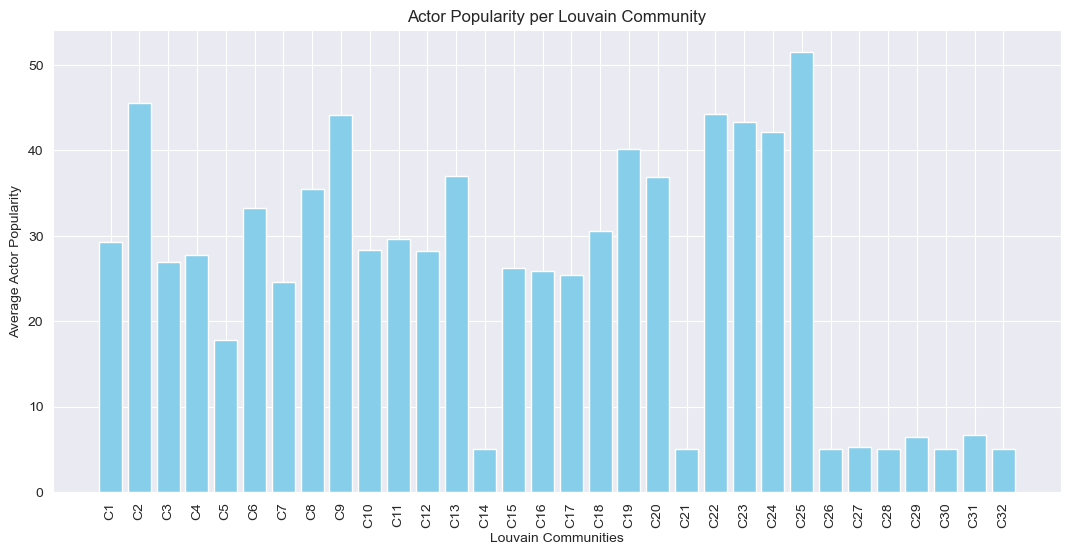

In [127]:
# Example data
data = {
    'Community': [f"C{i+1}" for i in range(len(communities))],
    'Popularity': average_popularities,
    'Sentiment': average_sentiments,
    'Profit': average_profits
}

# Convert data to a pandas DataFrame
import pandas as pd
df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(13, 6))
plt.bar(df['Community'], df['Popularity'], color='skyblue')
# Rotate x-axis labels vertically
plt.xticks(rotation=90)
plt.xlabel('Louvain Communities')
plt.ylabel('Average Actor Popularity')
plt.title('Actor Popularity per Louvain Community')
plt.show()

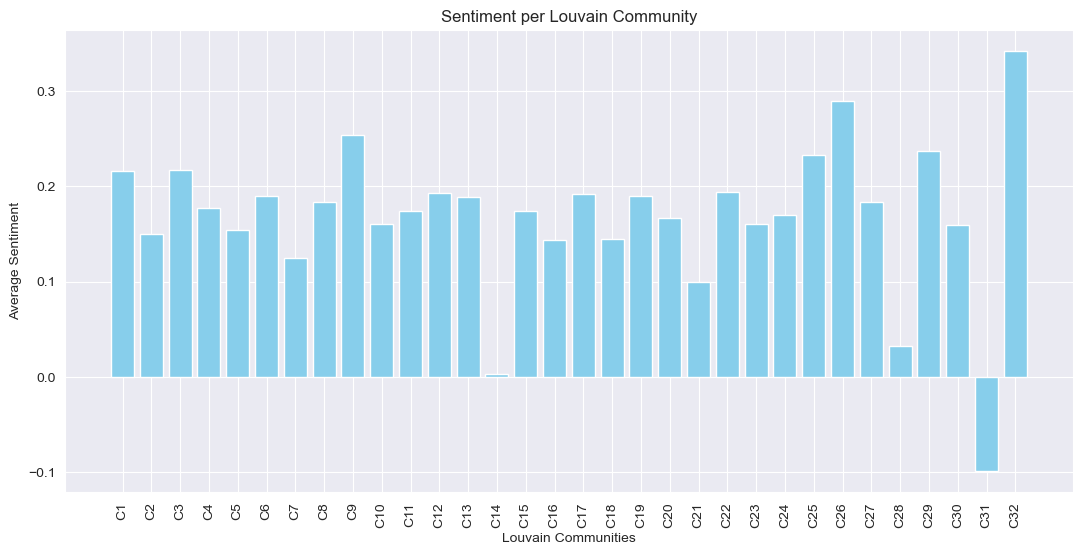

In [128]:
# Plot
plt.figure(figsize=(13, 6))
plt.bar(df['Community'], df['Sentiment'], color='skyblue')
# Rotate x-axis labels vertically
plt.xticks(rotation=90)
plt.xlabel('Louvain Communities')
plt.ylabel('Average Sentiment')
plt.title('Sentiment per Louvain Community')
plt.show()

Text(0.5, 1.0, 'Profit per Louvain Community')

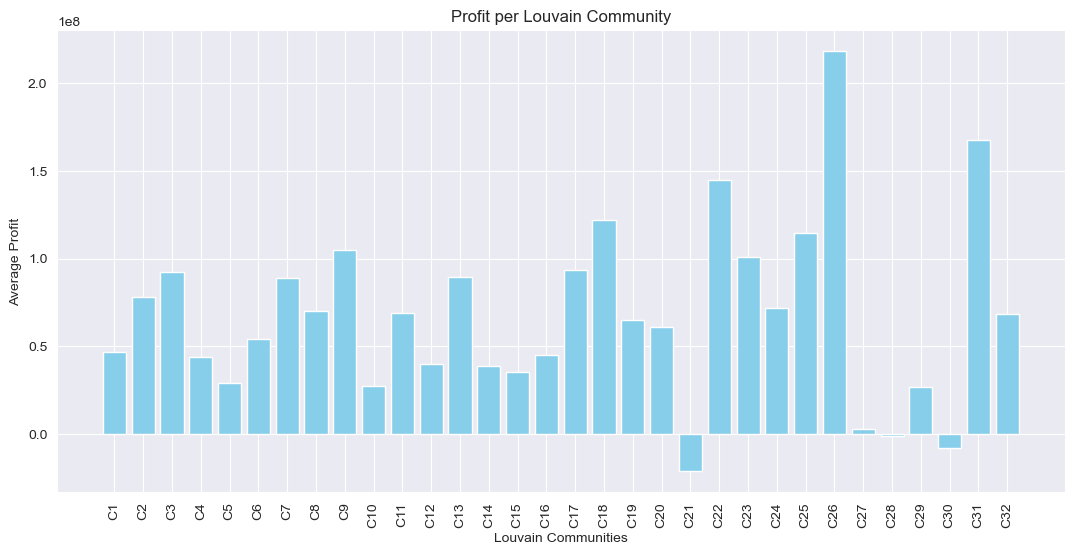

In [129]:
# Plot
plt.figure(figsize=(13, 6))
plt.bar(df['Community'], df['Profit'], color='skyblue')
# Rotate x-axis labels vertically
plt.xticks(rotation=90)
plt.xlabel('Louvain Communities')
plt.ylabel('Average Profit')
plt.title('Profit per Louvain Community')

### Sentiment Analysis in Louvain communities

In [131]:
# Group by Community and compute the variance of sentiment for communities
df.var(ddof=0, numeric_only=True).loc["Sentiment"]

0.006113614548264572

The low variance that we observe indicates consistent audience sentiment between communities.

Our next goal is to identify whether highly connected communities (which in our case means that are communities with more popular actors) show higher sentiment.

In [148]:
# Compute average degree for each community

average_degrees = {}
for index in range(len(communities)):
    community = communities[index]
    average_degrees[df.loc[index]["Community"]] = np.sum([d for movie, d in community.degree()]) / len(community)
    
df["Average Degree"] = average_degrees.values()

In [154]:
# Test if there is statistically significant correlation between the degree of a community and its average sentiment

# Calculate the Pearson correlation coefficient and p-value
corr, p_value = stats.pearsonr(df['Average Degree'], df['Sentiment'])

# Print results
print(f"Pearson correlation coefficient: {corr}")
print(f"P-value: {p_value}")

# Check if p-value is less than significance level (e.g., 0.05)
if p_value < 0.05:
    print("The correlation is statistically significant.")
else:
    print("The correlation is not statistically significant.")
    
spearman_corr, spearman_p = stats.spearmanr(df['Average Degree'], df['Sentiment'])
# Print results
print(f"\n\nSpearman correlation coefficient: {spearman_corr}")
print(f"P-value: {spearman_p}")

# Check if p-value is less than significance level (e.g., 0.05)
if spearman_p < 0.05:
    print("The correlation is statistically significant.")
else:
    print("The correlation is not statistically significant.")

Pearson correlation coefficient: 0.23358460303027917
P-value: 0.19820971008882404
The correlation is not statistically significant.


Spearman correlation coefficient: 0.1871849352476394
P-value: 0.30496107145961276
The correlation is not statistically significant.
